## Accelerate Inference: Neural Network Pruning

In [ ]:
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# untar
!ls
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

dataset.tar.gz	sample_data
train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [ ]:
train_images = torch.tensor(train_images, dtype=torch.float32)
val_images = torch.tensor(val_images, dtype=torch.float32)

train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)

In [ ]:
train_dataset = TensorDataset(train_images,
                              torch.tensor(train_labels.squeeze(), dtype=torch.long))
val_dataset = TensorDataset(val_images,
                            torch.tensor(val_labels.squeeze(), dtype=torch.long))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.model = nn.Sequential(
            # First block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Second block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Flatten layer
            nn.Flatten(),

            # Fully connected block: Dense -> ReLU -> Dropout -> Dense
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = ConvNet()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

In [ ]:
model = model.to(device)
summary(model, input_size=(3, 25, 25))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             896
       BatchNorm2d-2           [-1, 32, 25, 25]              64
              ReLU-3           [-1, 32, 25, 25]               0
            Conv2d-4           [-1, 32, 23, 23]           9,248
       BatchNorm2d-5           [-1, 32, 23, 23]              64
              ReLU-6           [-1, 32, 23, 23]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
           Dropout-8           [-1, 32, 11, 11]               0
            Conv2d-9           [-1, 64, 11, 11]          18,496
      BatchNorm2d-10           [-1, 64, 11, 11]             128
             ReLU-11           [-1, 64, 11, 11]               0
           Conv2d-12             [-1, 64, 9, 9]          36,928
      BatchNorm2d-13             [-1, 64, 9, 9]             128
             ReLU-14             [-1, 6

In [ ]:
def get_bn_weights(model):
    bn_weights = []
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            bn_weights.append(module.weight)
    return bn_weights

In [ ]:
def get_bn_params(model):
    bn_weights = []
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            bn_weights.append(m.weight)
    return bn_weights

In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device, lambda_l1=5e-4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        ce_loss = criterion(outputs, labels)

        # === Add L1 Regularization on BatchNorm weights ===
        l1_loss = 0
        for w in get_bn_weights(model):
            l1_loss += torch.norm(w, 1)
        loss = ce_loss + lambda_l1 * l1_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for the validation loop
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():  # Disable gradient calculations for validation
        for inputs, labels in val_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update tqdm description with current validation loss and accuracy
            val_loader_tqdm.set_postfix(loss=val_loss / total, accuracy=100 * correct / total)

    val_accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)
    return val_loss, val_accuracy

In [ ]:
# Main training loop
num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/100


Epoch [1/100], Train Loss: 1.4929, Train Acc: 0.39%, Val Loss: 1.2225, Val Acc: 48.79%
Epoch 2/100


Epoch [2/100], Train Loss: 1.3185, Train Acc: 0.49%, Val Loss: 1.1606, Val Acc: 51.60%
Epoch 3/100


Epoch [3/100], Train Loss: 1.2424, Train Acc: 0.53%, Val Loss: 1.0799, Val Acc: 55.92%
Epoch 4/100


Epoch [4/100], Train Loss: 1.1829, Train Acc: 0.56%, Val Loss: 1.0959, Val Acc: 54.69%
Epoch 5/100


Epoch [5/100], Train Loss: 1.1363, Train Acc: 0.58%, Val Loss: 1.0139, Val Acc: 58.57%
Epoch 6/100


Epoch [6/100], Train Loss: 1.0975, Train Acc: 0.60%, Val Loss: 0.9379, Val Acc: 61.98%
Epoch 7/100


Epoch [7/100], Train Loss: 1.0620, Train Acc: 0.62%, Val Loss: 0.9885, Val Acc: 59.92%
Epoch 8/100


Epoch [8/100], Train Loss: 1.0280, Train Acc: 0.63%, Val Loss: 0.8911, Val Acc: 64.95%
Epoch 9/100


Epoch [9/100], Train Loss: 0.9993, Train Acc: 0.64%, Val Loss: 0.8897, Val Acc: 64.91%
Epoch 10/100


Epoch [10/100], Train Loss: 0.9769, Train Acc: 0.65%, Val Loss: 0.8729, Val Acc: 65.19%
Epoch 11/100


Epoch [11/100], Train Loss: 0.9579, Train Acc: 0.66%, Val Loss: 0.9286, Val Acc: 63.64%
Epoch 12/100


Epoch [12/100], Train Loss: 0.9284, Train Acc: 0.68%, Val Loss: 0.9084, Val Acc: 64.71%
Epoch 13/100


Epoch [13/100], Train Loss: 0.9111, Train Acc: 0.68%, Val Loss: 0.8283, Val Acc: 68.00%
Epoch 14/100


Epoch [14/100], Train Loss: 0.8947, Train Acc: 0.69%, Val Loss: 0.8066, Val Acc: 68.20%
Epoch 15/100


Epoch [15/100], Train Loss: 0.8721, Train Acc: 0.70%, Val Loss: 0.8380, Val Acc: 67.05%
Epoch 16/100


Epoch [16/100], Train Loss: 0.8491, Train Acc: 0.71%, Val Loss: 0.7796, Val Acc: 69.43%
Epoch 17/100


Epoch [17/100], Train Loss: 0.8419, Train Acc: 0.71%, Val Loss: 0.8586, Val Acc: 68.04%
Epoch 18/100


Epoch [18/100], Train Loss: 0.8300, Train Acc: 0.72%, Val Loss: 0.7570, Val Acc: 71.17%
Epoch 19/100


Epoch [19/100], Train Loss: 0.8130, Train Acc: 0.72%, Val Loss: 0.7851, Val Acc: 69.86%
Epoch 20/100


Epoch [20/100], Train Loss: 0.7924, Train Acc: 0.73%, Val Loss: 0.8259, Val Acc: 68.67%
Epoch 21/100


Epoch [21/100], Train Loss: 0.7862, Train Acc: 0.73%, Val Loss: 0.7953, Val Acc: 69.27%
Epoch 22/100


Epoch [22/100], Train Loss: 0.7695, Train Acc: 0.74%, Val Loss: 0.7807, Val Acc: 70.46%
Epoch 23/100


Epoch [23/100], Train Loss: 0.7588, Train Acc: 0.75%, Val Loss: 0.7589, Val Acc: 71.76%
Epoch 24/100


Epoch [24/100], Train Loss: 0.7513, Train Acc: 0.75%, Val Loss: 0.7243, Val Acc: 72.55%
Epoch 25/100


Epoch [25/100], Train Loss: 0.7373, Train Acc: 0.75%, Val Loss: 0.7461, Val Acc: 71.60%
Epoch 26/100


Epoch [26/100], Train Loss: 0.7265, Train Acc: 0.76%, Val Loss: 0.7370, Val Acc: 71.76%
Epoch 27/100


Epoch [27/100], Train Loss: 0.7180, Train Acc: 0.76%, Val Loss: 0.7542, Val Acc: 72.08%
Epoch 28/100


Epoch [28/100], Train Loss: 0.7099, Train Acc: 0.77%, Val Loss: 0.7288, Val Acc: 72.87%
Epoch 29/100


Epoch [29/100], Train Loss: 0.6998, Train Acc: 0.77%, Val Loss: 0.7110, Val Acc: 73.43%
Epoch 30/100


Epoch [30/100], Train Loss: 0.6900, Train Acc: 0.77%, Val Loss: 0.7117, Val Acc: 73.78%
Epoch 31/100


Epoch [31/100], Train Loss: 0.6776, Train Acc: 0.78%, Val Loss: 0.7103, Val Acc: 73.27%
Epoch 32/100


Epoch [32/100], Train Loss: 0.6650, Train Acc: 0.78%, Val Loss: 0.7149, Val Acc: 72.48%
Epoch 33/100


Epoch [33/100], Train Loss: 0.6533, Train Acc: 0.79%, Val Loss: 0.7353, Val Acc: 72.51%
Epoch 34/100


Epoch [34/100], Train Loss: 0.6515, Train Acc: 0.79%, Val Loss: 0.7002, Val Acc: 73.47%
Epoch 35/100


Epoch [35/100], Train Loss: 0.6423, Train Acc: 0.79%, Val Loss: 0.7115, Val Acc: 73.23%
Epoch 36/100


Epoch [36/100], Train Loss: 0.6328, Train Acc: 0.79%, Val Loss: 0.6849, Val Acc: 73.66%
Epoch 37/100


Epoch [37/100], Train Loss: 0.6247, Train Acc: 0.80%, Val Loss: 0.7518, Val Acc: 72.51%
Epoch 38/100


Epoch [38/100], Train Loss: 0.6193, Train Acc: 0.80%, Val Loss: 0.7252, Val Acc: 73.39%
Epoch 39/100


Epoch [39/100], Train Loss: 0.6106, Train Acc: 0.80%, Val Loss: 0.7162, Val Acc: 73.54%
Epoch 40/100


Epoch [40/100], Train Loss: 0.6092, Train Acc: 0.80%, Val Loss: 0.6922, Val Acc: 74.26%
Epoch 41/100


Epoch [41/100], Train Loss: 0.5962, Train Acc: 0.81%, Val Loss: 0.6610, Val Acc: 75.37%
Epoch 42/100


Epoch [42/100], Train Loss: 0.5821, Train Acc: 0.82%, Val Loss: 0.7008, Val Acc: 74.42%
Epoch 43/100


Epoch [43/100], Train Loss: 0.5796, Train Acc: 0.81%, Val Loss: 0.7053, Val Acc: 74.50%
Epoch 44/100


Epoch [44/100], Train Loss: 0.5687, Train Acc: 0.82%, Val Loss: 0.6489, Val Acc: 75.41%
Epoch 45/100


Epoch [45/100], Train Loss: 0.5720, Train Acc: 0.82%, Val Loss: 0.6863, Val Acc: 74.26%
Epoch 46/100


Epoch [46/100], Train Loss: 0.5586, Train Acc: 0.82%, Val Loss: 0.7060, Val Acc: 73.90%
Epoch 47/100


Epoch [47/100], Train Loss: 0.5543, Train Acc: 0.83%, Val Loss: 0.7061, Val Acc: 74.34%
Epoch 48/100


Epoch [48/100], Train Loss: 0.5456, Train Acc: 0.83%, Val Loss: 0.6547, Val Acc: 75.52%
Epoch 49/100


Epoch [49/100], Train Loss: 0.5389, Train Acc: 0.83%, Val Loss: 0.6568, Val Acc: 75.45%
Epoch 50/100


Epoch [50/100], Train Loss: 0.5341, Train Acc: 0.84%, Val Loss: 0.6882, Val Acc: 74.85%
Epoch 51/100


Epoch [51/100], Train Loss: 0.5272, Train Acc: 0.83%, Val Loss: 0.6714, Val Acc: 75.84%
Epoch 52/100


Epoch [52/100], Train Loss: 0.5259, Train Acc: 0.84%, Val Loss: 0.6475, Val Acc: 76.51%
Epoch 53/100


Epoch [53/100], Train Loss: 0.5192, Train Acc: 0.84%, Val Loss: 0.6754, Val Acc: 75.84%
Epoch 54/100


Epoch [54/100], Train Loss: 0.5148, Train Acc: 0.84%, Val Loss: 0.6831, Val Acc: 75.25%
Epoch 55/100


Epoch [55/100], Train Loss: 0.5085, Train Acc: 0.84%, Val Loss: 0.6589, Val Acc: 76.16%
Epoch 56/100


Epoch [56/100], Train Loss: 0.4998, Train Acc: 0.85%, Val Loss: 0.6829, Val Acc: 75.72%
Epoch 57/100


Epoch [57/100], Train Loss: 0.4942, Train Acc: 0.85%, Val Loss: 0.6629, Val Acc: 75.88%
Epoch 58/100


Epoch [58/100], Train Loss: 0.4928, Train Acc: 0.85%, Val Loss: 0.6767, Val Acc: 76.20%
Epoch 59/100


Epoch [59/100], Train Loss: 0.4883, Train Acc: 0.85%, Val Loss: 0.6702, Val Acc: 76.12%
Epoch 60/100


Epoch [60/100], Train Loss: 0.4794, Train Acc: 0.85%, Val Loss: 0.6830, Val Acc: 76.20%
Epoch 61/100


Epoch [61/100], Train Loss: 0.4772, Train Acc: 0.86%, Val Loss: 0.6800, Val Acc: 75.60%
Epoch 62/100


Epoch [62/100], Train Loss: 0.4669, Train Acc: 0.86%, Val Loss: 0.6608, Val Acc: 76.63%
Epoch 63/100


Epoch [63/100], Train Loss: 0.4611, Train Acc: 0.86%, Val Loss: 0.6594, Val Acc: 76.83%
Epoch 64/100


Epoch [64/100], Train Loss: 0.4684, Train Acc: 0.86%, Val Loss: 0.6471, Val Acc: 77.23%
Epoch 65/100


Epoch [65/100], Train Loss: 0.4552, Train Acc: 0.86%, Val Loss: 0.6835, Val Acc: 76.20%
Epoch 66/100


Epoch [66/100], Train Loss: 0.4482, Train Acc: 0.86%, Val Loss: 0.7012, Val Acc: 76.32%
Epoch 67/100


Epoch [67/100], Train Loss: 0.4450, Train Acc: 0.87%, Val Loss: 0.7197, Val Acc: 75.76%
Epoch 68/100


Epoch [68/100], Train Loss: 0.4504, Train Acc: 0.86%, Val Loss: 0.6956, Val Acc: 76.28%
Epoch 69/100


Epoch [69/100], Train Loss: 0.4395, Train Acc: 0.87%, Val Loss: 0.6907, Val Acc: 76.79%
Epoch 70/100


Epoch [70/100], Train Loss: 0.4394, Train Acc: 0.87%, Val Loss: 0.6832, Val Acc: 76.20%
Epoch 71/100


Epoch [71/100], Train Loss: 0.4325, Train Acc: 0.87%, Val Loss: 0.7078, Val Acc: 76.20%
Epoch 72/100


Epoch [72/100], Train Loss: 0.4226, Train Acc: 0.88%, Val Loss: 0.6869, Val Acc: 77.07%
Epoch 73/100


Epoch [73/100], Train Loss: 0.4233, Train Acc: 0.87%, Val Loss: 0.6738, Val Acc: 77.90%
Epoch 74/100


Epoch [74/100], Train Loss: 0.4247, Train Acc: 0.88%, Val Loss: 0.6741, Val Acc: 77.47%
Epoch 75/100


Epoch [75/100], Train Loss: 0.4107, Train Acc: 0.88%, Val Loss: 0.6670, Val Acc: 77.03%
Epoch 76/100


Epoch [76/100], Train Loss: 0.4150, Train Acc: 0.88%, Val Loss: 0.6849, Val Acc: 76.75%
Epoch 77/100


Epoch [77/100], Train Loss: 0.4079, Train Acc: 0.88%, Val Loss: 0.6731, Val Acc: 77.86%
Epoch 78/100


Epoch [78/100], Train Loss: 0.4073, Train Acc: 0.88%, Val Loss: 0.6824, Val Acc: 77.47%
Epoch 79/100


Epoch [79/100], Train Loss: 0.4027, Train Acc: 0.88%, Val Loss: 0.6936, Val Acc: 77.74%
Epoch 80/100


Epoch [80/100], Train Loss: 0.3915, Train Acc: 0.89%, Val Loss: 0.6798, Val Acc: 77.07%
Epoch 81/100


Epoch [81/100], Train Loss: 0.3968, Train Acc: 0.89%, Val Loss: 0.6663, Val Acc: 77.70%
Epoch 82/100


Epoch [82/100], Train Loss: 0.3903, Train Acc: 0.89%, Val Loss: 0.7020, Val Acc: 76.87%
Epoch 83/100


Epoch [83/100], Train Loss: 0.3879, Train Acc: 0.89%, Val Loss: 0.6990, Val Acc: 76.59%
Epoch 84/100


Epoch [84/100], Train Loss: 0.3827, Train Acc: 0.89%, Val Loss: 0.6599, Val Acc: 77.27%
Epoch 85/100


Epoch [85/100], Train Loss: 0.3870, Train Acc: 0.89%, Val Loss: 0.6921, Val Acc: 77.03%
Epoch 86/100


Epoch [86/100], Train Loss: 0.3788, Train Acc: 0.89%, Val Loss: 0.7004, Val Acc: 77.47%
Epoch 87/100


Epoch [87/100], Train Loss: 0.3795, Train Acc: 0.89%, Val Loss: 0.6600, Val Acc: 78.30%
Epoch 88/100


Epoch [88/100], Train Loss: 0.3734, Train Acc: 0.89%, Val Loss: 0.6854, Val Acc: 77.19%
Epoch 89/100


Epoch [89/100], Train Loss: 0.3746, Train Acc: 0.89%, Val Loss: 0.6826, Val Acc: 78.22%
Epoch 90/100


Epoch [90/100], Train Loss: 0.3646, Train Acc: 0.90%, Val Loss: 0.7233, Val Acc: 77.27%
Epoch 91/100


Epoch [91/100], Train Loss: 0.3700, Train Acc: 0.89%, Val Loss: 0.7168, Val Acc: 76.79%
Epoch 92/100


Epoch [92/100], Train Loss: 0.3638, Train Acc: 0.90%, Val Loss: 0.6816, Val Acc: 77.54%
Epoch 93/100


Epoch [93/100], Train Loss: 0.3659, Train Acc: 0.90%, Val Loss: 0.6890, Val Acc: 77.58%
Epoch 94/100


Epoch [94/100], Train Loss: 0.3532, Train Acc: 0.90%, Val Loss: 0.6967, Val Acc: 77.94%
Epoch 95/100


Epoch [95/100], Train Loss: 0.3543, Train Acc: 0.90%, Val Loss: 0.6908, Val Acc: 77.98%
Epoch 96/100


Epoch [96/100], Train Loss: 0.3535, Train Acc: 0.90%, Val Loss: 0.7025, Val Acc: 77.82%
Epoch 97/100


Epoch [97/100], Train Loss: 0.3479, Train Acc: 0.90%, Val Loss: 0.6842, Val Acc: 77.19%
Epoch 98/100


Epoch [98/100], Train Loss: 0.3477, Train Acc: 0.90%, Val Loss: 0.7045, Val Acc: 77.39%
Epoch 99/100


Epoch [99/100], Train Loss: 0.3374, Train Acc: 0.91%, Val Loss: 0.6934, Val Acc: 77.94%
Epoch 100/100


Epoch [100/100], Train Loss: 0.3470, Train Acc: 0.90%, Val Loss: 0.7104, Val Acc: 77.27%


In [ ]:
torch.save(model.state_dict(), 'my_model_before_prune.pt', _use_new_zipfile_serialization=False)

In [ ]:
import matplotlib.pyplot as plt

def plot_bn_weights(model, title="BatchNorm γ Distribution"):
    bn_weights = []
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            bn_weights.append(module.weight.detach().cpu().numpy())

    all_weights = np.concatenate(bn_weights)
    plt.figure(figsize=(8, 5))
    plt.hist(all_weights, bins=100, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel("γ value (BN weights)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

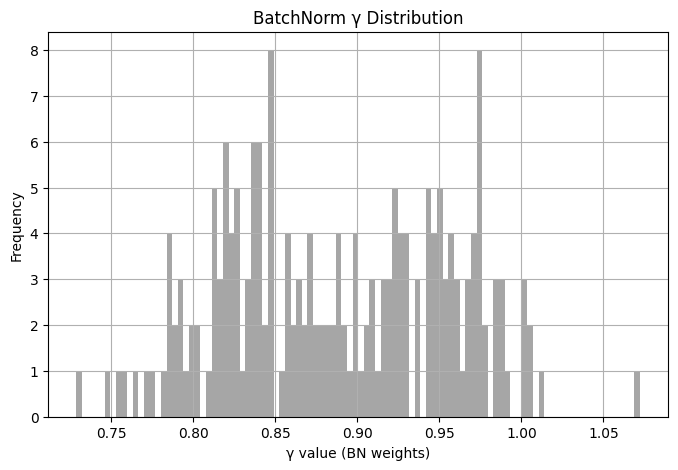

In [ ]:
plot_bn_weights(model)

In [ ]:
def compute_bn_threshold(model, pruning_ratio):
    bn_weights = []
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            bn_weights.append(module.weight.detach().abs().clone())

    all_weights = torch.cat(bn_weights)
    threshold = torch.quantile(all_weights, pruning_ratio)
    print(f"Pruning Threshold (γ): {threshold:.6f}")
    return threshold

In [ ]:
import copy


def prune_model(model, threshold=0.5, input_size=(3, 25, 25)):

    keep_idx_list = []

    # Get device from model
    device = next(model.parameters()).device

    layers = list(model.model)
    new_layers = []
    in_channels = 3
    prev_keep_idx = None

    # Track processed layers
    processed_indices = set()

    for idx in range(len(layers)):
        # Skip already processed
        if idx in processed_indices:
            continue

        layer = layers[idx]

        # Conv + BN block
        if isinstance(layer, nn.Conv2d) and idx + 1 < len(layers) and isinstance(layers[idx+1], nn.BatchNorm2d):
            bn = layers[idx+1]
            gamma = bn.weight.data.abs()
            keep_idx = torch.where(gamma >= threshold)[0]


            # Keep at least one channel
            if len(keep_idx) == 0:
                keep_idx = torch.tensor([torch.argmax(gamma)], device=gamma.device)

            keep_idx_list.append(keep_idx.cpu())

            # Calculate input channels
            new_in_channels = len(prev_keep_idx) if prev_keep_idx is not None else in_channels

            # Create pruned Conv layer
            new_conv = nn.Conv2d(
                in_channels=new_in_channels,
                out_channels=len(keep_idx),
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
                bias=layer.bias is not None
            ).to(device)

            # Copy pruned weights
            w = layer.weight.data
            if prev_keep_idx is not None:
                w = w[:, prev_keep_idx]
            new_conv.weight.data = w[keep_idx].clone()

            # Copy bias if present
            if layer.bias is not None:
                new_conv.bias.data = layer.bias.data[keep_idx].clone()

            new_layers.append(new_conv)

            # Create pruned BN layer
            new_bn = nn.BatchNorm2d(len(keep_idx)).to(device)
            new_bn.weight.data = bn.weight.data[keep_idx].clone()
            new_bn.bias.data = bn.bias.data[keep_idx].clone()
            new_bn.running_mean.data = bn.running_mean.data[keep_idx].clone()
            new_bn.running_var.data = bn.running_var.data[keep_idx].clone()
            new_layers.append(new_bn)

            # Mark BN as processed
            processed_indices.add(idx + 1)
            prev_keep_idx = keep_idx

        # Linear layer
        elif isinstance(layer, nn.Linear):
            if prev_keep_idx is not None:
                try:
                    with torch.no_grad():
                        # Create partial model with layers so far
                        partial_model = nn.Sequential(*new_layers).to(device)
                        # Generate dummy input on same device
                        dummy_input = torch.randn(1, *input_size, device=device)
                        # Forward pass
                        dummy_output = partial_model(dummy_input)
                        # Get flattened size
                        in_features = dummy_output.numel()

                        # Create new Linear with correct dimensions
                        new_linear = nn.Linear(in_features, layer.out_features).to(device)
                        # Copy bias
                        new_linear.bias.data = layer.bias.data.clone()
                        new_layers.append(new_linear)
                except Exception as e:
                    print(f"Error when processing Linear layer: {e}")
                    # Fallback
                    new_layers.append(copy.deepcopy(layer).to(device))
            else:
                # Copy as is
                new_layers.append(copy.deepcopy(layer).to(device))
        else:
            # Other layers (ReLU, MaxPool, etc.)
            new_layers.append(copy.deepcopy(layer).to(device))

    # Return the complete pruned model
    return nn.Sequential(*new_layers), keep_idx_list

In [ ]:
class PrunedNet(nn.Module):
    def __init__(self, pruned_seq_model):
        super(PrunedNet, self).__init__()
        self.model = pruned_seq_model

    def forward(self, x):
        return self.model(x)

In [ ]:
import torch.optim as optim

def fine_tune(model, train_loader, val_loader, epochs=50, lr=0.0001, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / total

        # Evaluate
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

In [ ]:
def evaluate(model, loader, device=None):
    model.eval()
    correct = 0
    total = 0
    if device is None:
        device = next(model.parameters()).device

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")
    return acc

In [ ]:
def zero_small_weights(model, threshold=1e-3):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if "weight" in name:
                param[torch.abs(param) < threshold] = 0

In [ ]:
# # Step 1
# gamma_threshold = compute_bn_threshold(model, pruning_ratio=0.4)

# # Step 2
# pruned_model, keep_idxs = prune_model(model, threshold=gamma_threshold)

# # Step 3
# pruned_net = PrunedNet(pruned_model).to(device)
# fine_tune(pruned_net, train_loader, val_loader, epochs=50, lr=1e-4)

# # Step 4
# zero_small_weights(pruned_net, threshold=1e-2)

# # calculate sparsity
# def count_nonzero_and_total(model):
#     num_zero = 0
#     total = 0
#     for param in model.parameters():
#         if param.requires_grad:
#             total += param.numel()
#             num_zero += torch.sum(param == 0).item()
#     return num_zero, total

# num_zero, total = count_nonzero_and_total(baseline_model)
# print(f"Zero weights: {num_zero}, Total parameters: {total}")

# # Step 5
# acc = evaluate(pruned_net, val_loader)
# zero, total = count_nonzero_and_total(pruned_net)
# sparsity = zero / total
# score = (acc + sparsity) / 2 if acc > 0.6 else 0

# print(f"Final Score: {score:.4f} | Accuracy: {acc:.4f} | Sparsity: {sparsity:.4f}")

In [ ]:
def run_pruning_sweep(model, train_loader, val_loader,
                      pruning_ratios=[0.3, 0.4, 0.5, 0.6],
                      input_size=(3, 25, 25),
                      fine_tune_epochs=50,
                      fine_tune_lr=1e-4,
                      zero_threshold=1e-2):

    import copy

    results = []
    best_score = 0
    best_model = None

    for ratio in pruning_ratios:
        print(f"\n🚀 Trying pruning_ratio = {ratio}")
        model_copy = copy.deepcopy(model)  # 保留原始模型
        gamma_threshold = compute_bn_threshold(model_copy, pruning_ratio=ratio)

        # Step 2: Prune
        pruned_model, keep_idxs = prune_model(model_copy, threshold=gamma_threshold, input_size=input_size)
        pruned_net = PrunedNet(pruned_model).to(device)

        # Step 3: Fine-tune
        fine_tune(pruned_net, train_loader, val_loader, epochs=fine_tune_epochs, lr=fine_tune_lr)

        # Step 4: Zeroing
        zero_small_weights(pruned_net, threshold=zero_threshold)

        # Step 5: Evaluate
        acc = evaluate(pruned_net, val_loader)

        def count_nonzero_and_total(model):
            num_zero = 0
            total = 0
            for param in model.parameters():
                if param.requires_grad:
                    total += param.numel()
                    num_zero += torch.sum(param == 0).item()
            return num_zero, total

        zero, total = count_nonzero_and_total(pruned_net)
        sparsity = zero / total
        score = (acc + sparsity) / 2 if acc > 0.6 else 0

        print(f"✅ Ratio={ratio:.2f} | Acc={acc:.4f} | Sparsity={sparsity:.4f} | Score={score:.4f}")

        results.append((ratio, gamma_threshold.item(), acc, sparsity, score))

        if score > best_score:
            best_score = score
            best_model = copy.deepcopy(pruned_net)
            torch.save(best_model.state_dict(), f"best_pruned_model_{ratio:.2f}.pt")

    return results

In [ ]:
results = run_pruning_sweep(model, train_loader, val_loader)


🚀 Trying pruning_ratio = 0.3
Pruning Threshold (γ): 0.840058
[Epoch 1] Train Loss: 1.0665, Train Acc: 0.5797, Val Acc: 0.6467
[Epoch 2] Train Loss: 0.8693, Train Acc: 0.6657, Val Acc: 0.6844
[Epoch 3] Train Loss: 0.8150, Train Acc: 0.6903, Val Acc: 0.6871
[Epoch 4] Train Loss: 0.7783, Train Acc: 0.7054, Val Acc: 0.6943
[Epoch 5] Train Loss: 0.7497, Train Acc: 0.7156, Val Acc: 0.7259
[Epoch 6] Train Loss: 0.7311, Train Acc: 0.7226, Val Acc: 0.7105
[Epoch 7] Train Loss: 0.7154, Train Acc: 0.7285, Val Acc: 0.7299
[Epoch 8] Train Loss: 0.6955, Train Acc: 0.7366, Val Acc: 0.7137
[Epoch 9] Train Loss: 0.6921, Train Acc: 0.7375, Val Acc: 0.7386
[Epoch 10] Train Loss: 0.6740, Train Acc: 0.7441, Val Acc: 0.7240
[Epoch 11] Train Loss: 0.6709, Train Acc: 0.7455, Val Acc: 0.7176
[Epoch 12] Train Loss: 0.6563, Train Acc: 0.7521, Val Acc: 0.7370
[Epoch 13] Train Loss: 0.6426, Train Acc: 0.7549, Val Acc: 0.7350
[Epoch 14] Train Loss: 0.6264, Train Acc: 0.7640, Val Acc: 0.7426
[Epoch 15] Train Loss: 

In [ ]:
torch.save(pruned_model.state_dict(), 'my_model_best_v2-1.pt', _use_new_zipfile_serialization=False)

In [ ]:
pruned_dict = torch.load('my_model_best_v2-1.pt', map_location='cpu')
print(pruned_dict.keys())


In [ ]:
# original architecture
class ConvNet_1(nn.Module):
    def __init__(self):
        super(ConvNet_1, self).__init__()

        self.model = nn.Sequential(
            # First block: Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Second block: Conv -> ReLU -> Conv -> ReLU -> MaxPool -> Dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Flatten layer
            nn.Flatten(),

            # Fully connected block: Dense -> ReLU -> Dropout -> Dense -> Softmax
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# transfer to original architecture

import torch
import torch.nn as nn

baseline_model = ConvNet_1()
baseline_sd = baseline_model.state_dict()

pruned_sd = torch.load("my_model_best_v2-1.pt", map_location='cpu')

# map pruned_sd key and baseline key
mapping = {
    '0': 'model.0',
    '3': 'model.2',
    '8': 'model.6',
    '11': 'model.8',
    '17': 'model.13',
    '20': 'model.16',
}

prev_out_channels = None

for i, (pruned_key, base_key) in enumerate(mapping.items()):
    w = pruned_sd[f"{pruned_key}.weight"]
    b = pruned_sd[f"{pruned_key}.bias"]

    new_w = torch.zeros_like(baseline_sd[f"{base_key}.weight"])
    new_b = torch.zeros_like(baseline_sd[f"{base_key}.bias"])

    if i < 4:  # Conv layers
        out_channels = w.shape[0]
        in_channels = w.shape[1]

        out_keep = torch.arange(out_channels)

        if prev_out_channels is not None:
            in_keep = torch.arange(prev_out_channels)
            new_w[out_keep[:, None], in_keep] = w
        else:
            new_w[out_keep] = w  # first conv layer

        new_b[out_keep] = b
        prev_out_channels = out_channels

    else:  # FC layers
        new_w[:w.shape[0], :w.shape[1]] = w
        new_b[:b.shape[0]] = b

    baseline_sd[f"{base_key}.weight"] = new_w
    baseline_sd[f"{base_key}.bias"] = new_b

baseline_model.load_state_dict(baseline_sd)
torch.save(baseline_model.state_dict(), "submission_baseline.pt", _use_new_zipfile_serialization=False)
print("Transfer complete!")


In [ ]:
from torchsummary import summary

baseline_model = baseline_model.to(device)
summary(baseline_model, input_size=(3, 25, 25), device=str(device))


In [ ]:

points = np.array([[sparsity, acc] for _, _, acc, sparsity, _ in results])
# Step 1: Sort by sparsity
points = points[np.argsort(points[:, 0])]

# Step 2: Find Pareto frontier (non-dominated points)
pareto = []
current_max_acc = 0
for s, acc in points[::-1]:  # Reverse scan from high sparsity
    if acc >= current_max_acc:
        pareto.append((s, acc))
        current_max_acc = acc

pareto = np.array(pareto[::-1])  # Reverse back for plotting


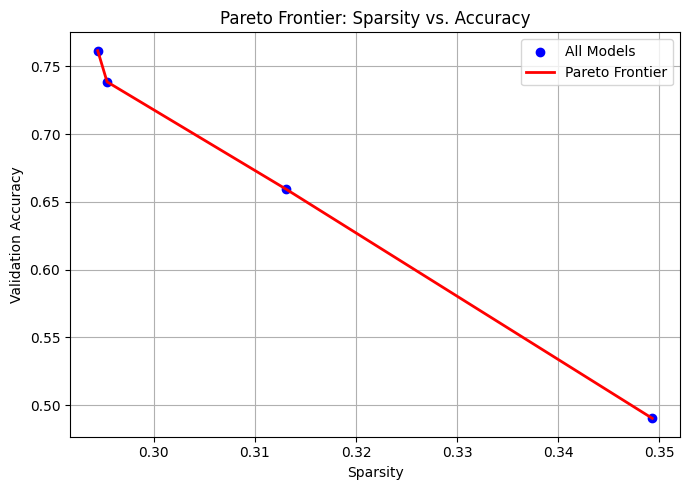

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(points[:, 0], points[:, 1], color='blue', label='All Models')
plt.plot(pareto[:, 0], pareto[:, 1], color='red', linewidth=2, label='Pareto Frontier')

plt.xlabel("Sparsity")
plt.ylabel("Validation Accuracy")
plt.title("Pareto Frontier: Sparsity vs. Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("Pruning Ratio | Sparsity  | Accuracy")
print("-" * 35)
for ratio, threshold, acc, sparsity, score in results:
    print(f"{ratio:13.2f} | {sparsity:9.4f} | {acc:8.4f}")


Pruning Ratio | Sparsity  | Accuracy
-----------------------------------
         0.30 |    0.2944 |   0.7616
         0.40 |    0.2954 |   0.7386
         0.50 |    0.3131 |   0.6594
         0.60 |    0.3493 |   0.4903
